### Загрузка датасета COCO и кода COCO API
Необходимо раскомментировать код ниже. В нём происходит скачивание и распаковка датасета COCO.
Кроме того, здесь клонируется репозиторий с кодом COCO API (код для работы с данными из COCO)

Запускать лучше всего в Google Cloab или на другой Linux-машине

In [1]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2023-03-09 04:08:52--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.128.131, 52.217.89.92, 52.217.138.209, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.128.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  33.8MB/s    in 11m 26s 

2023-03-09 04:20:18 (26.9 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2023-03-09 04:20:18--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.138.249, 52.217.138.33, 52.217.131.233, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.138.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[=================

### Импорт необходимых библиотек

In [2]:
import os
import skimage.io as io
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, UpSampling2D)
import matplotlib.pyplot as plt

### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [3]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [4]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [5]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [6]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=28.41s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [7]:
size = 256
train_ds = COCO_dataset_train.train_dataset(32, 32, size)
val_ds = COCO_dataset_val.val_dataset(32, size)

### Проверка изображений ###

In [8]:
images, labels = list(val_ds.take(2).as_numpy_iterator())[1]

def image_show(valid_img, valid_hm = None):


  if valid_hm is None:
    print('Show predict heatmap\n')
    for i in range(valid_img.shape[0]):
      pred = model.predict(valid_img[i][None, ...])
      seg_map = (pred[0, ..., 0] > 0.6).astype(np.float32)
      seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
      plt.imshow(valid_img[i] * 0.5 + seg_map_clr * 0.5)
      plt.show()  

  else:
    assert valid_hm.shape[0] == valid_img.shape[0], 'valid_hm count not equal valid_img'
    print('Show validation heatmap\n')
    for i in range(valid_img.shape[0]):
      seg_map = (valid_hm[i, ..., 0] > 0.5).astype(np.float32)
      seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
      plt.imshow(valid_img[i] * 0.5 + seg_map_clr * 0.5)
      plt.show()



Show validation heatmap



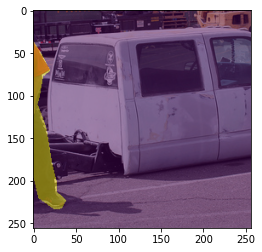

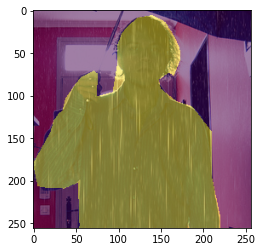

In [9]:
image_show(images[:2, ...], valid_hm = labels[:2, ...])

## Модель построил на основе видело https://www.youtube.com/watch?v=OWK8VlgJM4I ##

In [11]:
resnet = tf.keras.applications.ResNet50V2(weights = 'imagenet', input_shape = (size, size, 3), include_top = False)

94668760/94668760 [==============================] - 3s 0us/step


In [12]:
resnet.trainable = False

In [13]:
# Слои из ResNet50 для конкретинации
conv1 = resnet.get_layer('conv1_conv').output # 128
conv2 = resnet.get_layer('conv2_block3_1_relu').output # 64
conv3 = resnet.get_layer('conv3_block4_1_relu').output # 32
conv4 = resnet.get_layer('conv4_block6_1_relu').output # 16
conv5 = resnet.get_layer('post_relu').output # 8

# Block  8 => 16
up_conv5 = UpSampling2D(2, interpolation = 'bilinear')(conv5)
conc_5_4 = tf.concat([up_conv5, conv4], axis = 3)
conv_5_4 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(conc_5_4)

# Block  16 => 32
up_conv4 = UpSampling2D(2, interpolation = 'bilinear')(conv_5_4)
conc_4_3 = tf.concat([up_conv4, conv3], axis = 3)
conv_4_3 = Conv2D(128, (3, 3), padding  ='same', activation = 'relu')(conc_4_3)

# Block  32 => 64
up_conv3 = UpSampling2D(2, interpolation = 'bilinear')(conv_4_3)
conc_3_2 = tf.concat([up_conv3, conv2], axis = 3)
conv_3_2 = Conv2D(64, (3, 3), padding  ='same', activation = 'relu')(conc_3_2)

# Block  64 => 128
up_conv2 = UpSampling2D(2, interpolation = 'bilinear')(conv_3_2)
conc_2_1 = tf.concat([up_conv2, conv1], axis = 3)
conv_2_1 = Conv2D(32, (3, 3), padding  ='same', activation = 'relu')(conc_2_1)

# Block  128 => 256
up_conv1 = UpSampling2D(2, interpolation = 'bilinear')(conv_2_1)
conv_out = Conv2D(1, (3, 3), padding  ='same', activation = 'sigmoid')(up_conv1)

model = tf.keras.Model(inputs = resnet.input, outputs = conv_out)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Обучение модели ##

In [15]:
history = model.fit(train_ds, batch_size = 64, epochs = 32, steps_per_epoch = 128)

Epoch 1/32
128/128 [==============================] - 95s 737ms/step - loss: 0.1453
Epoch 2/32
128/128 [==============================] - 96s 751ms/step - loss: 0.1433
Epoch 3/32
128/128 [==============================] - 96s 754ms/step - loss: 0.1433
Epoch 4/32
128/128 [==============================] - 96s 749ms/step - loss: 0.1426
Epoch 5/32
128/128 [==============================] - 97s 761ms/step - loss: 0.1462
Epoch 6/32
128/128 [==============================] - 96s 748ms/step - loss: 0.1459
Epoch 7/32
128/128 [==============================] - 98s 764ms/step - loss: 0.1511
Epoch 8/32
128/128 [==============================] - 97s 756ms/step - loss: 0.1471
Epoch 9/32
128/128 [==============================] - 97s 755ms/step - loss: 0.1386
Epoch 10/32
128/128 [==============================] - 98s 768ms/step - loss: 0.1465
Epoch 11/32
128/128 [==============================] - 97s 755ms/step - loss: 0.1398
Epoch 12/32
128/128 [==============================] - 97s 755ms/step - lo

## Инференс ##

In [ ]:
model.save('resnet_semantic_segment')

In [18]:
model = tf.keras.models.load_model('/content/resnet_semantic_segment')

Show predict heatmap

1/1 [==============================] - 1s 1s/step


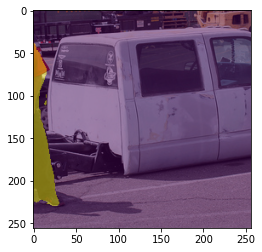

1/1 [==============================] - 0s 33ms/step


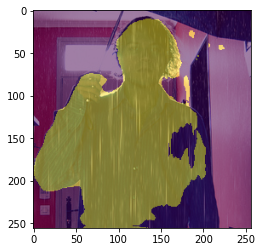

1/1 [==============================] - 0s 35ms/step


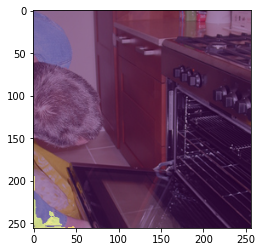

1/1 [==============================] - 0s 40ms/step


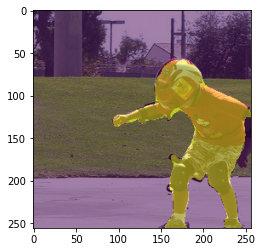

1/1 [==============================] - 0s 32ms/step


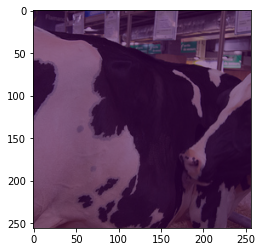

1/1 [==============================] - 0s 34ms/step


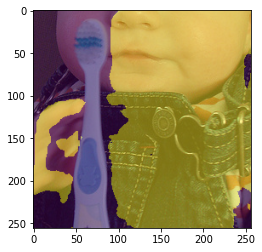

1/1 [==============================] - 0s 33ms/step


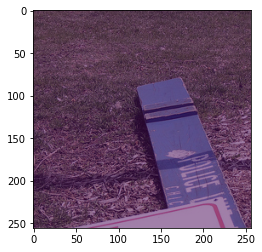

1/1 [==============================] - 0s 42ms/step


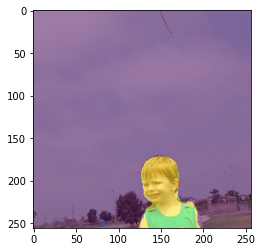

1/1 [==============================] - 0s 32ms/step


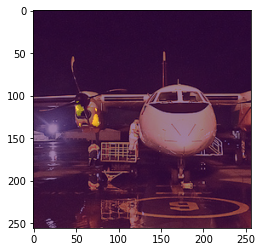

1/1 [==============================] - 0s 32ms/step


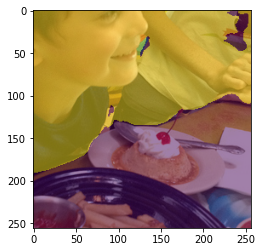

1/1 [==============================] - 0s 32ms/step


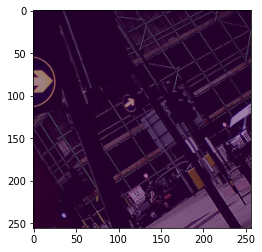

1/1 [==============================] - 0s 34ms/step


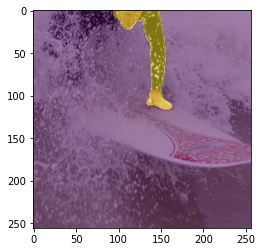

1/1 [==============================] - 0s 31ms/step


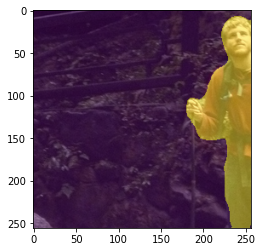

1/1 [==============================] - 0s 32ms/step


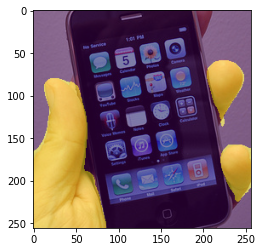

1/1 [==============================] - 0s 32ms/step


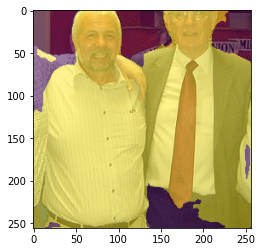

1/1 [==============================] - 0s 31ms/step


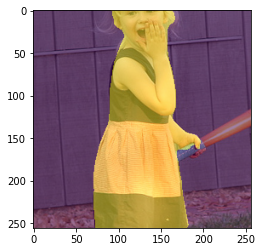

1/1 [==============================] - 0s 33ms/step


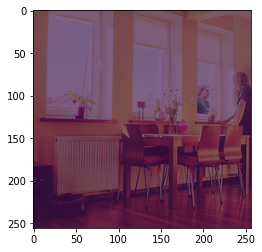

1/1 [==============================] - 0s 30ms/step


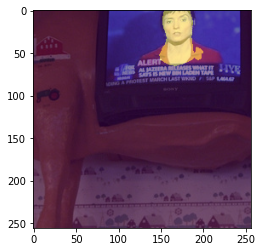

1/1 [==============================] - 0s 32ms/step


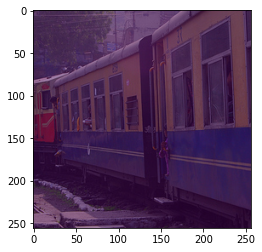

1/1 [==============================] - 0s 31ms/step


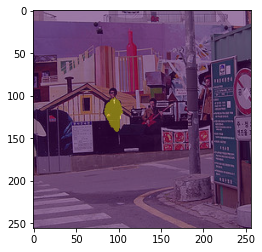

1/1 [==============================] - 0s 31ms/step


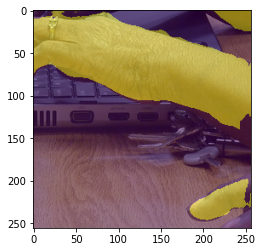

1/1 [==============================] - 0s 32ms/step


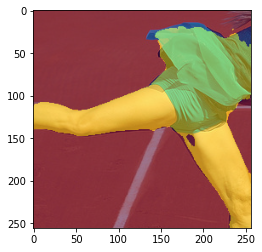

1/1 [==============================] - 0s 33ms/step


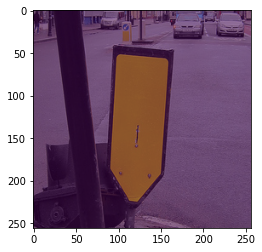

1/1 [==============================] - 0s 33ms/step


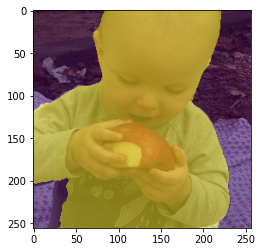

1/1 [==============================] - 0s 31ms/step


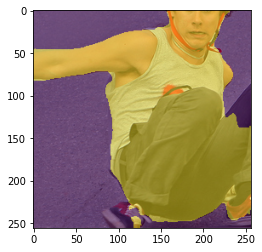

1/1 [==============================] - 0s 35ms/step


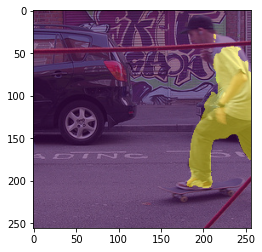

1/1 [==============================] - 0s 33ms/step


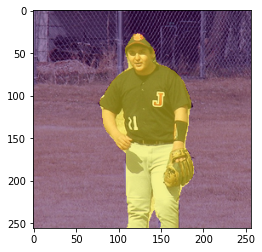

1/1 [==============================] - 0s 60ms/step


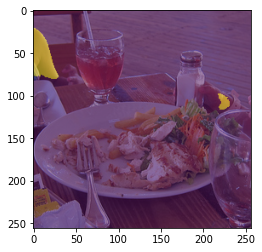

1/1 [==============================] - 0s 60ms/step


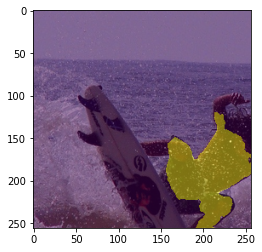

1/1 [==============================] - 0s 44ms/step


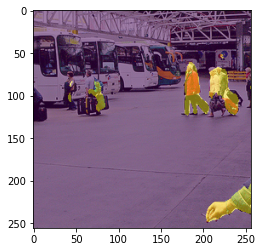

1/1 [==============================] - 0s 45ms/step


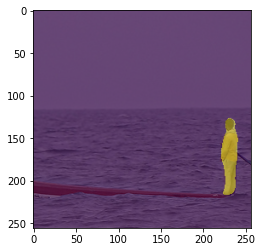

1/1 [==============================] - 0s 47ms/step


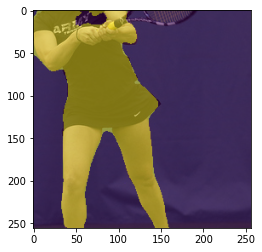

In [20]:
image_show(images[:32])

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# zip архивация модели на google drive
!zip -r /content/drive/MyDrive/resnet_semantic_segmet.zip /content/resnet_semantic_segment

  adding: content/resnet_semantic_segment/ (stored 0%)
  adding: content/resnet_semantic_segment/fingerprint.pb (stored 0%)
  adding: content/resnet_semantic_segment/saved_model.pb (deflated 92%)
  adding: content/resnet_semantic_segment/assets/ (stored 0%)
  adding: content/resnet_semantic_segment/keras_metadata.pb (deflated 96%)
  adding: content/resnet_semantic_segment/variables/ (stored 0%)
  adding: content/resnet_semantic_segment/variables/variables.index (deflated 78%)
  adding: content/resnet_semantic_segment/variables/variables.data-00000-of-00001 (deflated 7%)


## Сжатие модели путем квантования ##

In [23]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from pathlib import Path
import time
import pathlib
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm

In [24]:
tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

SAVED_MODEL = "/content/resnet_semantic_segment"
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)

In [25]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [26]:
weights_tflite_model_file = 'converted_model.tflite'

interpreter = tf.lite.Interpreter(model_path=weights_tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

### Сравнение моделей ###

In [46]:
# первоначальная модель
saved_model = Path(SAVED_MODEL)
full_model_size = sum(f.stat().st_size for f in saved_model.glob('**/*') if f.is_file() )/(1024*1024)
print(f'Full model size {full_model_size} MB')

start_time = time.time()
pred_just_model = model.predict(images[0][None, ...])
print(f'Predictions full model calculated in {time.time() - start_time} seconds')

Full model size 160.9366979598999 MB
1/1 [==============================] - 0s 70ms/step
Predictions full model calculated in 0.23382854461669922 seconds


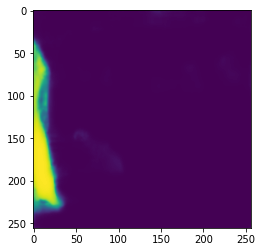

In [45]:
plt.imshow(pred_just_model[0])

In [48]:
# кватования модель
converted_model = Path(tflite_model_file)
converted_model_size = converted_model.stat().st_size / (1024*1024)
print(f'\nConverted model size {converted_model_size} MB')

start_time = time.time()
interpreter.set_tensor(input_index, images[0][None, ...].astype(np.float32))
interpreter.invoke()
pred_conv_model = interpreter.get_tensor(output_index)
print(f'Predictions converted model calculated in {time.time() - start_time} seconds')


Converted model size 28.571563720703125 MB
Predictions converted model calculated in 0.31605076789855957 seconds


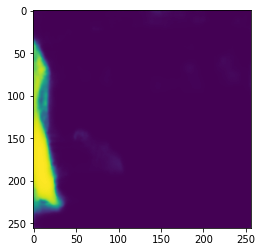

In [43]:
plt.imshow(pred_conv_model[0])